In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.resnet50 import ResNet50
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [2]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/amrragababdelaziz/dermnet-and-skin-disease-9-classes')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

















Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds

Your Kaggle username: rubinie

Your Kaggle Key: ··········



100%|██████████| 3.51G/3.51G [00:27<00:00, 135MB/s]


In [3]:
train ='/content/dermnet-and-skin-disease-9-classes/Merged Dataset/Train'
validation_dir = '/content/dermnet-and-skin-disease-9-classes/Merged Dataset/test'

In [4]:
import glob
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [5]:
train_samples =get_files(train)
num_classes=len(glob.glob(train+"/*"))
test_samples=get_files(validation_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

9 Classes

26642 Train images

2389 Test images


In [6]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)
img_width,img_height =128,128
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train,
                                target_size=(img_width,img_height),batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(validation_dir,shuffle=True,target_size=(img_width,img_height),batch_size=batch_size)

Found 26642 images belonging to 9 classes.

Found 2389 images belonging to 9 classes.


In [7]:
od.download('https://www.kaggle.com/datasets/keras/resnet50')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds

Your Kaggle username: rubinie

Your Kaggle Key: ··········



100%|██████████| 174M/174M [00:00<00:00, 189MB/s]


In [8]:
model = Sequential()
#vgg-16 , 80% accuracy with 100 epochs
# model.add(VGG16(input_shape=(224,224,3),pooling='avg',classes=1000,weights=vgg16_weights_path))
#resnet-50 , 87% accuracy with 100 epochs
model.add(ResNet50(include_top=False,input_tensor=None,input_shape=(128,128,3),pooling='avg',classes=2,weights="imagenet"))
model.add(Flatten())

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(9, activation='sigmoid'))

# model.layers[0].trainable = False
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 2048)              23587712  

                                                                 

 flatten (Flatten)           (None, 2048)              0         

                                                                 

 dropout (Dropout)           (None, 2048)              0         

                                                                 

 batch_normalization (BatchN  (None, 2048)             8192      

 ormalization)                                                   

                                                                 

 dense (Dense)               (None, 256)               524544    

                                                                 

 dropout_1 (Dropout)         (None, 256)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
history = model.fit(train_generator,validation_data=test_generator,epochs=50,shuffle=True)

Epoch 1/50

833/833 [==============================] - 414s 429ms/step - loss: 1.8531 - accuracy: 0.3449 - val_loss: 2.2081 - val_accuracy: 0.1737

Epoch 2/50

833/833 [==============================] - 347s 416ms/step - loss: 1.5145 - accuracy: 0.4450 - val_loss: 2.0179 - val_accuracy: 0.2897

Epoch 3/50

833/833 [==============================] - 340s 408ms/step - loss: 1.4142 - accuracy: 0.4848 - val_loss: 1.9029 - val_accuracy: 0.3026

Epoch 4/50

833/833 [==============================] - 337s 405ms/step - loss: 1.3308 - accuracy: 0.5116 - val_loss: 1.7912 - val_accuracy: 0.3512

Epoch 5/50

833/833 [==============================] - 338s 406ms/step - loss: 1.2590 - accuracy: 0.5455 - val_loss: 1.8796 - val_accuracy: 0.3357

Epoch 6/50

833/833 [==============================] - 337s 405ms/step - loss: 1.2039 - accuracy: 0.5630 - val_loss: 1.7590 - val_accuracy: 0.3767

Epoch 7/50

833/833 [==============================] - 337s 404ms/step - loss: 1.1518 - accuracy: 0.5853 - val_l

75/75 [==============================] - 19s 228ms/step


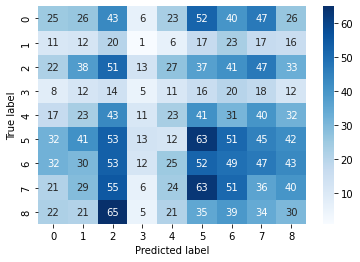

In [10]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [11]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print(report)

75/75 [==============================] - 16s 215ms/step

                                                                    precision    recall  f1-score   support



Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.07      0.05      0.06       288

                                          Atopic Dermatitis Photos       0.04      0.07      0.05       123

                                                     Eczema Photos       0.14      0.18      0.16       309

                               Melanoma Skin Cancer Nevi and Moles       0.07      0.04      0.05       116

                                Nail Fungus and other Nail Disease       0.10      0.07      0.08       261

             Psoriasis pictures Lichen Planus and related diseases       0.15      0.16      0.16       352

                      Seborrheic Keratoses and other Benign Tumors       0.15      0.15      0.15       343

            Tinea Ringworm Candidiasis and other Fungal Infections   

In [16]:
model.save('resnet_model.h5')

In [24]:
img='/content/dermnet-and-skin-disease-9-classes/Merged Dataset/Train/Melanoma Skin Cancer Nevi and Moles/ISIC_6653780.jpg'

In [25]:
def predict_disease(test_image):
  img = cv2.imread(test_image)
  img = img / 255.0
  img = cv2.resize(img, (128, 128))
  img = img.reshape(1,128,128,3)
  prediction = model.predict(img)
  pred_class = np.argmax(prediction, axis = -1)
  return pred_class

In [26]:
pred=predict_disease(img)
d=pred[0]

1/1 [==============================] - 0s 48ms/step


In [27]:
skin_conditions = [    "Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions",    "Atopic Dermatitis Photos",    "Eczema Photos",    "Melanoma Skin Cancer Nevi and Moles",    "Nail Fungus and other Nail Disease",    "Psoriasis pictures Lichen Planus and related diseases",    "Seborrheic Keratoses and other Benign Tumors",    "Tinea Ringworm Candidiasis and other Fungal Infections",    "Warts Molluscum and other Viral Infections"]


In [28]:
skin_conditions[d]

'Melanoma Skin Cancer Nevi and Moles'